## Import & Get MNIST Data

In [1]:
from sklearn.datasets import fetch_openml
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from bayes_opt import BayesianOptimization
from sklearn.preprocessing import LabelBinarizer
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb                       # Lightgbm 패키지
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import KFold   # K-Fold CV
from functools import partial

In [2]:
from sklearn.preprocessing import label_binarize
mnist = fetch_openml('mnist_784', version=1)
X,y=mnist["data"],mnist["target"]
y=y.astype(np.int)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=50000, test_size=20000, stratify=y, random_state=42)

In [3]:
X_train.shape, y_train.shape

((50000, 784), (50000,))

## LGBM Multiclass Model w/o PCA -> micro / macro F1

In [4]:
def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [5]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha, reg_lambda, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data[train_index], y_data[train_index]
        x_valid, y_valid = x_data[valid_index], y_data[valid_index]
        
        model = lgb.LGBMClassifier(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            subsample = np.clip(subsample, 0, 1), 
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict_proba(x_valid)
        pred = [np.argmax(line) for line in pred]
        score += multiclass_roc_auc_score(y_valid, pred,average='micro')/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [6]:
# 모델과 관련없는 변수 고정
func_fixed = partial(lgb_cv, x_data=X_train, y_data=y_train, n_splits=5, output='score') 
# 베이지안 최적화 범위 설정
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),        # num_leaves,       범위(16~1024)
        'learning_rate': (0.0001, 0.1),  # learning_rate,    범위(0.0001~0.1)
        'n_estimators': (16, 1024),      # n_estimators,     범위(16~1024)
        'subsample': (0, 1),             # subsample,        범위(0~1)
        'colsample_bytree': (0, 1),      # colsample_bytree, 범위(0~1)
        'reg_alpha': (0, 10),            # reg_alpha,        범위(0~10)
        'reg_lambda': (0, 50),           # reg_lambda,       범위(0~50)
    }, 
    random_state=4321                    # 시드 고정
)
lgbBO.maximize(init_points=5, n_iter=5)

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.9842   |  0.0708   |  0.08152  |  790.0    |  304.6    |  1.931    |  48.95    |  0.4062   |
|  2        |  0.9706   |  0.7578   |  0.009006 |  328.4    |  639.9    |  4.599    |  10.92    |  0.6635   |
|  3        |  0.9833   |  0.6787   |  0.09504  |  299.5    |  640.8    |  3.833    |  20.02    |  0.9427   |
|  4        |  0.9818   |  0.9299   |  0.09484  |  394.5    |  361.0    |  6.648    |  2.116    |  0.2322   |
|  5        |  0.9811   |  0.4301   |  0.007886 |  788.7    |  876.7    |  1.504    |  5.057    |  0.2709   |
|  6        |  0.9392   |  0.6222   |  0.03011  |  17.29    |  17.06    |  8.005    |  30.57    |  0.4728   |
|  7        |  0.9579   |  0.9608   |  0.02043  |  27.04    |  1.023e+0 |  3.621    |  6.104    |  0.5903   |
|  8      

In [7]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=X_train, y_data=y_train, n_splits=5, output='model')

In [8]:
##5 kfold 예측
preds=[]
for model in models:
    pred = model.predict_proba(X_test)
    preds.append(pred)

pred = np.mean(preds,axis=0)
pred = [np.argmax(line) for line in pred]

In [9]:
#accuracy, confusion_maxtrix
from sklearn.metrics import accuracy_score

print(model.__class__.__name__, accuracy_score(y_test, pred))
print(); print(metrics.classification_report(y_test, pred))
print(); print(metrics.confusion_matrix(y_test, pred))

LGBMClassifier 0.97165

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1972
           1       0.98      0.98      0.98      2250
           2       0.97      0.97      0.97      1997
           3       0.97      0.97      0.97      2040
           4       0.97      0.96      0.97      1950
           5       0.98      0.96      0.97      1804
           6       0.97      0.98      0.98      1965
           7       0.97      0.97      0.97      2084
           8       0.96      0.97      0.97      1950
           9       0.95      0.95      0.95      1988

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000


[[1957    1    1    0    1    0    3    1    5    3]
 [   0 2215   12    4    2    1    3    6    6    1]
 [   7    3 1937    9    9    0    6   13   11    2]
 [   5    3   14 1970    0   12    2   12   14    8]
 [  

In [10]:
### MiCRO, MACRO ->multiclass 분류 성능 지표
n_classes=10
fpr = dict()
tpr = dict()
roc_auc = dict()

##타켓값을 원핫백터로 변환
lb = LabelBinarizer()
lb.fit(y_test)
y_test_one_hot = lb.transform(y_test)
pred = lb.transform(pred)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), np.array(pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [11]:
from scipy import interp

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

C:\Users\cke45\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


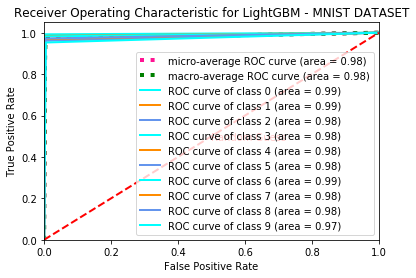

In [12]:
from itertools import cycle

lw=2
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LightGBM - MNIST DATASET')
plt.legend(loc="lower right")
plt.show()

## LGBM Multiclass Model w/ PCA -> micro / macro F1

In [13]:
## 154차원으로 축소
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

154

In [14]:
from sklearn.decomposition import PCA
rnd_pca = PCA(n_components=154, svd_solver="randomized") # stochastic PCA
X_train_reduced = rnd_pca.fit_transform(X_train)
X_test_reduced = rnd_pca.transform(X_test)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced.astype(np.float32))
X_test_scaled= scaler.fit_transform(X_test_reduced.astype(np.float32))

In [15]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=X_train_scaled , y_data=y_train, n_splits=5, output='model')

In [24]:
##5 kfold 예측
preds=[]
for model in models:
    pred = model.predict_proba(X_test_scaled)
    preds.append(pred)

pred=np.mean(preds,axis=0)
pred = [np.argmax(line) for line in pred]

In [25]:
#accuracy, confusion_maxtrix
print(model.__class__.__name__, accuracy_score(y_test, pred))
print(); print(metrics.classification_report(y_test, pred))
print(); print(metrics.confusion_matrix(y_test, pred))

LGBMClassifier 0.94745

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1972
           1       0.98      0.98      0.98      2250
           2       0.94      0.94      0.94      1997
           3       0.93      0.93      0.93      2040
           4       0.94      0.95      0.95      1950
           5       0.93      0.92      0.93      1804
           6       0.96      0.97      0.97      1965
           7       0.96      0.94      0.95      2084
           8       0.92      0.94      0.93      1950
           9       0.93      0.92      0.92      1988

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000


[[1931    0    6    1    2    6   12    2   11    1]
 [   0 2196   14    8    3   10    3   10    3    3]
 [   7    6 1887   23   15    1   12    9   36    1]
 [   2    4   30 1891    1   41    6   21   31   13]
 [  

In [26]:
### MiCRO, MACRO ->multiclass 분류 성능 지표
n_classes=10
fpr = dict()
tpr = dict()
roc_auc = dict()

##타켓값을 원핫백터로 변환
lb = LabelBinarizer()
lb.fit(y_test)
y_test_one_hot = lb.transform(y_test)
pred = lb.transform(pred)

#클래스별로 auc값 계산
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_one_hot.ravel(), np.array(pred).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [27]:
# macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

C:\Users\cke45\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


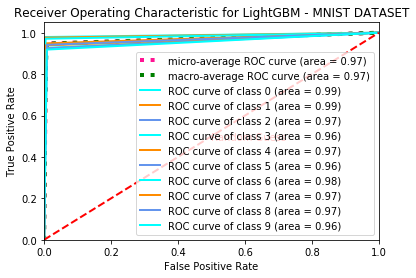

In [28]:
lw=2
# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for LightGBM - MNIST DATASET')
plt.legend(loc="lower right")
plt.show()